# 📥 Import Necessary Libraries 

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from statistics import mean 
from statistics import variance
from scipy import optimize
import matplotlib.pyplot as plt
import scipy.special
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import random
import numpy as np
from collections import deque
from collections import namedtuple
import numpy as np

# 💾 Data Preparation

In [2]:
plt.style.use('ggplot')
mydata = pd.read_csv('AAPL.csv')
mydata.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-24,160.750000,162.139999,159.639999,161.940002,160.110641,69463600
1,2021-11-26,159.570007,160.449997,156.360001,156.809998,155.038589,76959800
2,2021-11-29,159.369995,161.190002,158.789993,160.240005,158.429840,88748200
3,2021-11-30,159.990005,165.520004,159.919998,165.300003,163.432648,174048100
4,2021-12-01,167.479996,170.300003,164.529999,164.770004,162.908630,152052500


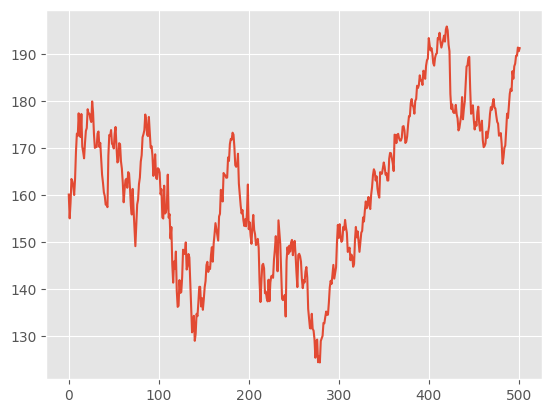

In [3]:
mydata['Adj Close'].plot();

# 🎲 Monte Carlo FrameWork

In [4]:
#project parameters:
T=1
r=0.025
K=170
k=7
s=0.02
sigma=0.02
V0 = 1.7
kappa = 2
theta=0.045
rho=-0.5711
time_steps=100
c=0.216
N=100000
LR=1e-4

### Heston Model stochastic differential equation :<bR>
$dS_t = \mu S_tdt +\sqrt{v_t}S_tdW_{t}^S $
<br>
$dv_t = \kappa(\theta - v_t)dt +\xi\sqrt{v_t}dW_{t}^v$

In [5]:
#Create Heston simulation Paths:    
def heston_paths(S, T, r, kappa, theta, v_0, rho, sigma,  steps, Npaths):
    dt = T/steps
    size = (Npaths, steps+1)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    prices[:, 0] = S_t
    sigs[:, 0] = v_t
    for t in range(1,steps+1):
        WT = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho],[rho,1]]), size=Npaths) * np.sqrt(dt)  
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + sigma*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    return prices

In [6]:
S=mydata['Adj Close'].iloc[-100]
data=heston_paths(S, T, r, kappa, theta, V0, rho, sigma,  100, 50000)

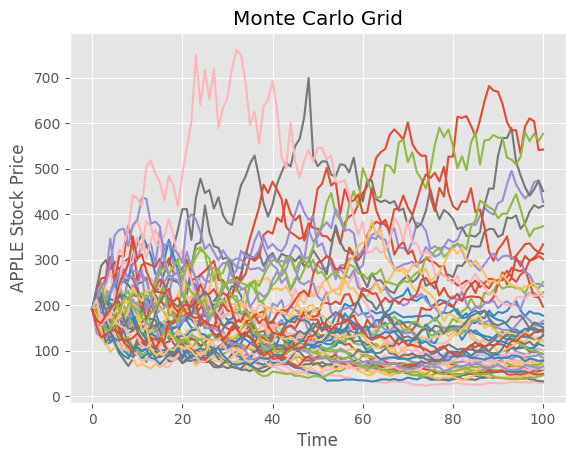

In [7]:
for i in range (50):
    plt.plot(data[i])
plt.xlabel('Time')  
plt.ylabel('APPLE Stock Price')  
# displaying the title 
plt.title("Monte Carlo Grid") 
plt.show()
T=100

# 🤖 Q-Learning

## Game: American Option
### An american option is a financial product that allows holders to exercise their rights at any time before and including the expiration date. In our case, we work with a put option on the APPLE stock, with a price $S$.  If we exercise the option, we get a return of $max(K-S,0)$ where $K$ is the strike price.
### Therefore we have only two actions: exercise or hold the option.

In [8]:
class Option:
    def play_step(self,S,t, action):
        #The option is excuted by the holder ot at the maturity, when we get a reward of the reurn, otherwise the reward is 0
        reward = 0
        done = (action==1)
        if done or (t == T-1):
            reward = max(K-S,0)
        return reward, done

## Model:  Linear_QNet with basis of Laguerre Polynomials
### We estimate the continuation value using this model

In [9]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 1)
    def forward(self, x, t):
        x = self.continuation_value(x,t)
        x = self.linear1(x)
        return x
    def continuation_value(self,x,t):
        cv=[1]
        x=x/K
        cv.append(math.exp(-x/2))
        cv.append(math.exp(-x/2)*(1 - x/2))
        cv.append(math.exp(-x/2)*(1 - 2*x +(x**2)/2))
        cv.append(math.sin((math.pi*(-t))/(2*T)+ math.pi/2 ))
        cv.append(math.log(T-t))
        cv.append(((t/T)**2))
        return(torch.FloatTensor((cv)))
    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

In [10]:
#Trainer of the model:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, t,state, action, reward, next_state, reward2, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        reward2= torch.tensor(reward2, dtype=torch.float)
        pred = self.model(state,t)
        target =self.gamma * torch.max(reward2, self.model(next_state,t+1))
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()

### Agent: reinforcement learning agent that trains the model to the optimal optimal action-value function Q* to achieve the highest reward. In our case, the agent will compare the values of immediate exercise of the option witht the continuation value and make the most profitable decision.

In [17]:
class Agent:
    def __init__(self, model=Linear_QNet(7)):
        self.n_games = 0
        self.epsilon = 0 
        self.gamma = 0.9
        self.memory = deque(maxlen=N) 
        self.model = model
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(S,t):
        state =S[t]
        return np.array(state)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train(self, t,state, action, reward, next_state,reward2, done):
        self.trainer.train_step(t, state, action, reward, next_state,reward2,  done)

    def get_action(self, state,t):
        state0 = torch.tensor(state, dtype=torch.float)
        prediction = self.model(state0,t)
        action = max(K-state0,0) > prediction
        return action


def train(data):
    plot_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = Option()
    for t in range(1,T-1):
        for j in range(N):
            S=data[j,:]
        
            action = agent.get_action(S[t],t)
            reward, done = game.play_step(S[t],t,action)
            reward2, done2 = game.play_step(S[t+1],t+1,1)
            # train 
            state_old=S[t]
            state_new=S[t+1]
            agent.train(t,state_old, action, reward, state_new,reward2, done)

            # remember
            agent.remember(state_old, action, reward, state_new, done)

            if done:
                if reward > record:
                    record = reward
                    agent.model.save()
                plot_scores.append(record)
                break
    plt.plot(plot_scores)
    plt.xlabel('Episodes')  
    plt.ylabel('Highest Reward Achieved')  
    # displaying the title 
    plt.title("Q-learning reward") 
    plt.show()

#  🎆  Acheiving Q*

C:\Users\youss\AppData\Local\Temp\ipykernel_22584\3973779474.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.long)


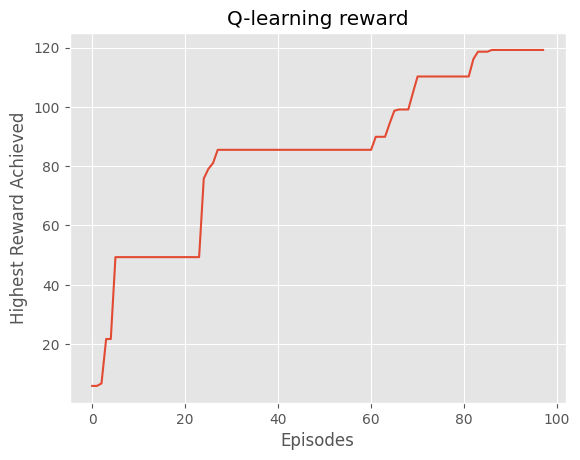

In [18]:
train(data);

In [19]:
test_data=mydata['Adj Close'].values[-101:]
model = Linear_QNet(7)
model.load_state_dict(torch.load("./model/model.pth"))
model.eval()
agent = Agent(model )
game = Option()
for t in range(len(test_data)-1):
    action=agent.get_action(test_data[t],t)
    reward, done = game.play_step(test_data[t],t,action)
    if done:
        print("The option was exercised at step ", t, " and reward was", round(reward,2))
        break
if not done:
    reward, done = game.play_step(len(test_data),len(test_data),1)
    print("The option was exercised at its maturity and reward was", round(reward,2))

The option was exercised at step  81  and reward was 3.33


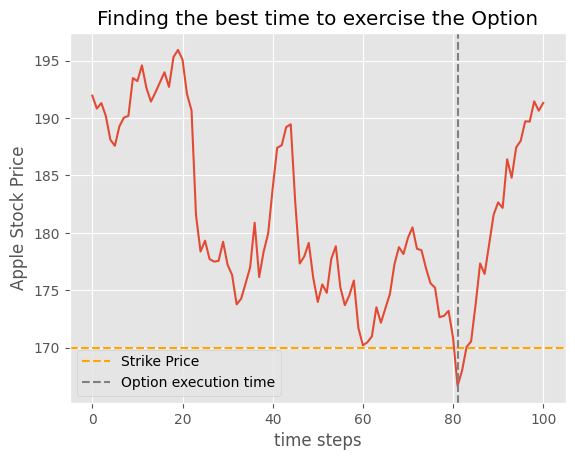

In [20]:

plt.plot(test_data)
plt.axhline(y = K, color = 'orange', linestyle = '--', label="Strike Price") 
plt.axvline(x = t, color = 'gray', linestyle = '--', label='Option execution time') 
plt.xlabel('time steps')  
plt.ylabel('Apple Stock Price')  
# displaying the title 
plt.title("Finding the best time to exercise the Option") 
plt.legend()
plt.show();